In [1]:
import pickle
import pandas as pd
import sys
import numpy as np

In [2]:
!ls

all_homes.ipynb


In [3]:
sys.path.append("../../code/")
sys.path.append("../code/")


from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [4]:
out_overall = pickle.load(open('../../data/input/all_regions.pkl', 'r'))


In [5]:
# Initialising results
results = {'KNN':{},'MF':{},'FHMM':{},'LBM':{},'RA':{}}

In [6]:
# Loading KNN results
knn_results = pickle.load(open('../data/knn_all_homes.pkl','r'))
for appliance, appliance_df in knn_results.iteritems():
    results['KNN'][appliance] = appliance_df.median().mean()

In [7]:
# Loading MF results and finding the best
mf_results = pickle.load(open('../data/mf_all_homes.pkl','r'))
best_combination = {}
for appliance, appliance_struct in mf_results.iteritems():
    best_appliance=1000
    for appliance_feature, appliance_feature_struct in appliance_struct.iteritems():
        for latent_factors, appliance_df in appliance_feature_struct.iteritems():
            pred = appliance_df.median().mean()
            if pred<best_appliance:
                best_appliance=pred
                best_combination[appliance]=(appliance_feature, latent_factors, pred)
                results['MF'][appliance] = pred

In [8]:
def get_fhmm(appliance):
    count = 0
    for test_region in ["Austin"]:
        out = {}
        test_df = out_overall[test_region]
        #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[appliance] = {}
        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        for test_home in test_df_appliance.index:
            try:
                #print test_home
                pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
                pred_df_appliance = pred_df[appliance].ix[start:stop-1]
                gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
                gt_df_appliance.index = pred_df_appliance.index
                error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
                #error[error>100]=100
                #acc = 100-error
                out[appliance][test_home]=error
            except:
                pass
    return pd.DataFrame(out[appliance]).T.median().mean()

In [9]:
lbm_pred_df = pickle.load(open('../data/lbm_15_Austin.pkl'))

In [10]:
def get_lbm(appliance, region):
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[region]
    #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
    pred_df = lbm_pred_df[['%s_%d' %(appliance,month) for month in range(start,stop)]]

    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return error.median().mean()

In [11]:
def get_regional_average(appliance, test_region='Austin'):
    try:
        contri_austin_appliance = contribution[test_region]['Cooling'][appliance]
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        test_df = out_overall[test_region]
        test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]

        test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
        pred_df = test_df_appliance[['aggregate_%d' %month for month in range(start, stop)]]*contri_austin_appliance
        gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
        gt_df.columns = pred_df.columns
        error = (gt_df-pred_df).abs().div(gt_df).mul(100)
        return error.median().mean()
    except:
        return np.NaN

In [12]:
for appliance in ['fridge','dw','mw','oven','hvac','wm']:
    print appliance
    results['FHMM'][appliance]=get_fhmm(appliance)
    results['LBM'][appliance] = get_lbm(appliance, "Austin")
    results['RA'][appliance] = get_regional_average(appliance)

fridge
dw
mw
oven
hvac
wm


In [67]:
%matplotlib inline
results_df = pd.DataFrame(results)

In [68]:
results_df

,FHMM,KNN,LBM,MF,RA
dw,1381.644002,52.700411,97.950250,46.081924,137.596039
fridge,35.694620,24.149983,19.604440,28.802623,49.693072
hvac,30.407670,25.236728,63.435324,22.589278,34.578255
mw,822.226612,59.344624,93.421598,52.009452,NaN
oven,3063.765939,50.354162,235.460335,45.006192,NaN
wm,944.352849,53.511891,2616.246376,50.545587,168.871129


In [69]:
map_appliance = {'fridge':'Fridge','dw':'Dish\nwasher','mw':'Microwave','hvac':'HVAC','oven':'Oven','wm':'Washing\nmachine'}

In [70]:
#results_df[results_df>100]=100
#results_df=results_df.fillna(100)
results_df.index = [map_appliance[appliance] for appliance in results_df.index]
#results_df.plot(kind='bar', colors=tableau20blind[::2])

In [71]:
results_df = results_df.ix[['HVAC','Fridge','Oven','Dish\nwasher','Washing\nmachine','Microwave']]

In [72]:
results_df = results_df[['FHMM','LBM','RA','KNN','MF']]

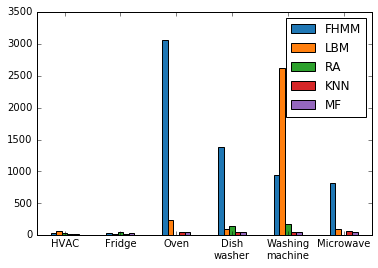

In [73]:
results_df.plot(kind='bar',rot=0, colors=tableau20blind[::2])

In [76]:
pd.set_option('precision',1)

In [77]:
results_df

,FHMM,LBM,RA,KNN,MF
HVAC,30.4,63.4,34.6,25.2,22.6
Fridge,35.7,19.6,49.7,24.1,28.8
Oven,3063.8,235.5,NaN,50.4,45.0
Dish\nwasher,1381.6,98.0,137.6,52.7,46.1
Washing\nmachine,944.4,2616.2,168.9,53.5,50.5
Microwave,822.2,93.4,NaN,59.3,52.0


In [80]:
out_overall['Austin']

,hvac_1,hvac_2,hvac_3,hvac_4,hvac_5,hvac_6,hvac_7,hvac_8,hvac_9,hvac_10,...,md_available,full_agg_available,ratio_min_max,difference_ratio_min_max,variance,skew,kurtosis,p_25,p_50,p_75
22,1.5e+02,1.1e+02,6.9e+01,8.2e+01,1.1e+02,135.3,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,3.6e-02,2.9e+00,1.4e+01,1.3e+02,2.4e+02,543.8,761.4,902.4,610.0,395.2,...,1,1,0.3,0.3,204787.4,7.1e-01,-0.8,704.4,868.6,1369.3
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,8.4e+02,5.9e+02,3.6e+02,2.7e+01,7.8e+01,198.0,458.0,700.4,244.3,81.1,...,1,1,0.4,0.4,180146.4,7.6e-01,-0.3,1041.1,1259.8,1719.5
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,8.1e+02,6.3e+02,3.8e+02,2.2e+02,3.2e+02,593.9,769.5,854.1,581.8,290.3,...,0,1,0.5,0.5,74286.9,1.4e-01,-1.1,960.3,1196.5,1390.4
86,4.2e-01,4.5e-01,3.2e+00,8.2e+01,1.7e+02,376.5,714.3,844.9,565.7,259.4,...,0,1,0.3,0.3,179432.4,1.7e-01,-1.0,850.5,1196.7,1497.6
93,2.9e+01,2.7e+01,4.2e+01,1.4e+02,2.7e+02,547.1,835.9,972.3,657.8,304.6,...,0,1,0.3,0.3,164263.4,8.4e-01,-0.6,485.0,713.8,1091.4
94,0.0e+00,3.5e-04,1.0e-04,5.8e+00,2.0e+01,66.6,126.1,155.0,93.0,33.4,...,1,1,0.4,0.4,11482.2,8.9e-01,0.2,294.4,348.0,388.9
101,1.6e-01,1.2e+00,1.5e+01,1.0e+02,1.9e+02,325.9,462.7,485.2,350.5,192.6,...,1,1,0.3,0.3,47735.2,5.3e-01,-1.2,325.5,476.2,700.7
